In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
home_path_results = "/Users/francisco/Documents/GitHub/Time-Series-Library/results/"

In [6]:
datasets_path = "/home/francisco/Documents/Practica/Time-Series-Library/datasets/"

In [7]:
coffe_df  = pd.read_csv(datasets_path+ 'Coffee_500Exog.csv')
coffe_results_df=  pd.read_csv(datasets_path+ 'Coffee_500Exog_results.csv')
sugar_df  = pd.read_csv(datasets_path+ 'Sugar_500Exog.csv')
sugar_results_df =  pd.read_csv(datasets_path+ 'Sugar_500Exog_results.csv')


In [5]:
coffe_df.head()

,date,id,value,Exog_1,Exog_2,Exog_3,Exog_4,Exog_5,Exog_6,Exog_7,...,Exog_491,Exog_492,Exog_493,Exog_494,Exog_495,Exog_496,Exog_497,Exog_498,Exog_499,Exog_500
0,2000-01-03,Coffee,114.15,0.85,4350,289.7,5.15,9699.0,1120.0,147.5,...,0.0,0.0,24.6,24.6,24.60,0.00,0.0,0.0,0.0,0.0
1,2000-01-10,Coffee,114.15,0.85,4350,286.0,5.20,9699.0,1120.0,147.5,...,0.0,0.0,28.1,23.6,25.85,2.76,0.0,0.0,0.0,0.0
2,2000-01-17,Coffee,112.55,0.86,4350,313.0,5.15,9699.0,1120.0,147.5,...,0.0,0.0,30.2,27.2,28.70,4.75,0.0,0.0,0.0,0.0
3,2000-01-24,Coffee,111.20,0.87,4350,313.6,5.26,9699.0,1120.0,147.5,...,0.0,0.0,31.9,24.1,28.00,5.33,0.0,0.0,0.0,0.0
4,2000-01-31,Coffee,114.70,0.83,4350,307.3,5.33,9699.0,1120.0,147.5,...,0.0,0.0,29.2,23.4,26.30,9.23,0.0,0.0,0.0,0.0


In [6]:
sugar_df.head()

,date,id,value,Exog_1,Exog_2,Exog_3,Exog_4,Exog_5,Exog_6,Exog_7,...,Exog_491,Exog_492,Exog_493,Exog_494,Exog_495,Exog_496,Exog_497,Exog_498,Exog_499,Exog_500
0,2000-01-03,Sugar,5.84,0.85,414.0,289.7,5.15,622.5,9699.0,96530,...,20.9,0.0,31.3,20.1,25.70,0.00,33.1,25.1,29.10,0.0
1,2000-01-10,Sugar,5.84,0.85,414.0,286.0,5.20,622.5,9699.0,96530,...,22.0,0.0,34.1,23.6,28.85,0.10,34.1,25.1,29.60,0.0
2,2000-01-17,Sugar,5.45,0.86,414.0,313.0,5.15,622.5,9699.0,96530,...,22.8,0.0,32.7,23.9,28.30,5.83,32.2,24.1,28.15,0.0
3,2000-01-24,Sugar,5.43,0.87,414.0,313.6,5.26,622.5,9699.0,96530,...,24.5,0.0,32.2,20.2,26.20,0.00,34.1,23.1,28.60,0.0
4,2000-01-31,Sugar,5.47,0.83,414.0,307.3,5.33,622.5,9699.0,96530,...,22.1,0.0,28.1,15.2,21.65,0.00,30.4,22.1,26.25,0.0


In [7]:
results_path = home_path_results +'long_term_forecast_coffee_TimesNet_custom_Coffee_500Exog.csv_bs128_lrtypeC_ftS_sl52_ll26_pl52_dm32_nh8_el3_dl2_df64_fc3_ebfixed_dtTrue_Exp_0/'

In [8]:
pred = np.load(results_path+'/pred.npy')
true = np.load(results_path+'/true.npy')

In [9]:
preds = np.squeeze(pred)
trues = np.squeeze(true)

In [10]:

trues.shape

(191, 52)

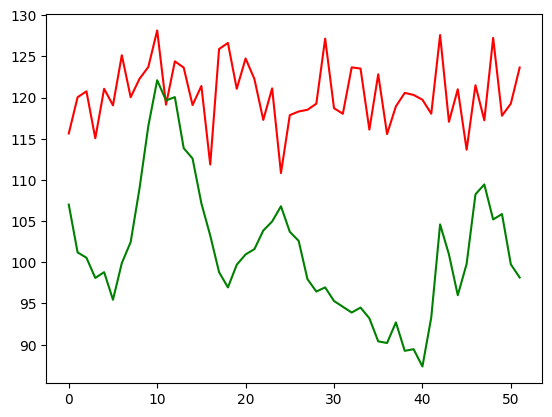

In [22]:
plt.plot(preds[0],'r')
plt.plot(trues[0],'g')

In [12]:
from sklearn.metrics import mean_squared_error

In [13]:
p = preds[190]
t = trues[190]

In [14]:
import numpy as np
MSE = np.mean((preds - trues)**2, axis=1)**(1/2)

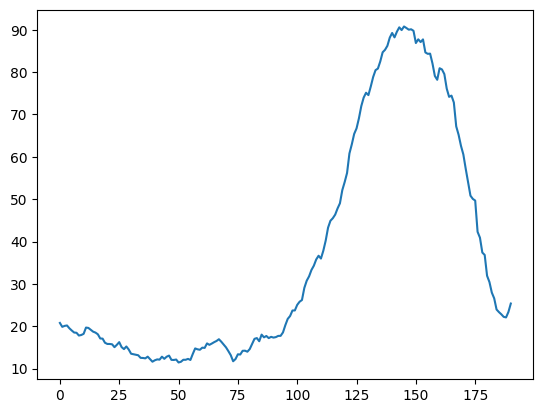

In [15]:
plt.plot(MSE)

In [16]:
mean_squared_error(t,p)**(1/2)

25.366388673132136

In [17]:
true_df = pd.DataFrame(trues)
pred_df = pd.DataFrame(preds)

In [18]:
cr =  coffe_results_df['units']

In [19]:
coffe_df[coffe_df['date']=='2021-12-20']

,date,id,value,Exog_1,Exog_2,Exog_3,Exog_4,Exog_5,Exog_6,Exog_7,...,Exog_491,Exog_492,Exog_493,Exog_494,Exog_495,Exog_496,Exog_497,Exog_498,Exog_499,Exog_500
1146,2021-12-20,Coffee,235.9,4.28,3440,1816.3,22.64,19648.0,2307.5,111.64,...,23.9,10.26,31.7,22.5,27.1,12.74,27.7,13.2,20.45,1.81


In [20]:
coffe_results_df.head()

,date,item,model,units,rmse,smape,forecast_accuracy,bias,lower,upper
0,2021-12-20,Coffee,xrnn,236.868011,0.968011,0.409508,99.589652,0.004087,228.219923,245.516100
1,2021-12-27,Coffee,xrnn,237.531372,6.331372,2.701493,97.261517,0.026655,225.848703,249.214041
2,2022-01-03,Coffee,xrnn,233.228180,7.128180,3.103742,96.847333,0.030563,219.202991,247.253369
3,2022-01-10,Coffee,xrnn,237.179077,1.270923,0.534418,99.467007,-0.005358,221.313663,253.044491
4,2022-01-17,Coffee,xrnn,231.875397,7.774603,3.297639,96.755851,-0.033529,214.395706,249.355087


- Formar datos de train y test
- Formar resultados de XRNN en un dataframe con las fechas como index, la primera columna con los valores reales y las siguientes columnas con los resultados de cada modelo

|date(index) | real_value | xrnn_results | timesnet_results | ... | 
| --- | --- | --- | --- | --- |
|2022-12-01 | 0.5 | 0.4 | 0.3 | ... |
|2023-01-01 | 0.6 | 0.5 | 0.7 | ... |
|2023-02-01 | 0.5 | 0.5 | 0.5 | ... |

- Al generar resultados debería entregarse una serie de pandas con las fechas como index y los valores de las predicciones
- Con eso se puede agregar al dataframe de los resultados haciendo un join con el index

- Las predicciones deben ser desde la fecha siguiente al presente virtual, por lo que en TimesNet debería ser el primer punto de predicción
- Calcular métricas de resultados: MSE, MAE, MAPE, RMSE